In [13]:
from nltk.corpus import brown
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import math
from itertools import combinations_with_replacement
import pandas as pd
import re
import pickle

In [14]:
#load the data from the pickle file
with open('corpus.pkl', 'rb') as f:
    tokenized_corpus, vocab, word2index, index2word = pickle.load(f)
flatten = lambda l: [item for sublist in l for item in sublist]
voc_size = len(vocab)

In [15]:
#2. BUilding the co-occurence matrix
# we are going to use the window size of 1 for simplicity to count the co-occurence of words

X_i = Counter(flatten(tokenized_corpus))
X_ij = Counter(combinations_with_replacement(flatten(tokenized_corpus), 2))






In [16]:
skip_grams = []
# we are going to make skip grams for each sentence in the corpus
#we are goonna loop through each sentence in the corpus
for sentence in tokenized_corpus:
    for i in range(1, len(sentence)-1):
        target = sentence[i]
        context = [sentence[i-1], sentence[i+1]]
        for word in context:
            skip_grams.append((target,word))

X_ik_skipgram = Counter(flatten(skip_grams)) 

In [17]:
#Weighing the co-occurence matrix ..just like professor code

def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [18]:
X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

# print(f"{X_ik=}")
# print(f"{weighting_dic=}")

In [19]:
#Preparing the data for the model
def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)


In [20]:

device = torch.device('cpu')

In [21]:
#testing the random batch function

batch_size = 2

input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, flatten(tokenized_corpus), skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

Input:  [[2672]
 [1533]]
Target:  [[1659]
 [  98]]
Cooc:  [[0.]
 [0.]]
Weighting:  [[0.03162278]
 [0.03162278]]


In [22]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [23]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
# let's train the model
import time 
num_epochs = 1000
for epoch in range(num_epochs):
    start_time = time.time()
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, flatten(tokenized_corpus), skip_grams, X_ik, weighting_dic)
    input_batch = torch.LongTensor(input_batch).to(device)
    target_batch = torch.LongTensor(target_batch).to(device)
    cooc_batch = torch.FloatTensor(cooc_batch).to(device)
    weighting_batch = torch.FloatTensor(weighting_batch).to(device)
    
    optimizer.zero_grad()
    loss = model
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    loss.backward()
    optimizer.step()

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tLoss: {loss.item():.3f}')

# let's see the embeddin

Epoch: 01 | Epoch Time: 0m 0s
	Loss: 0.727
Epoch: 101 | Epoch Time: 0m 0s
	Loss: 1.569
Epoch: 201 | Epoch Time: 0m 0s
	Loss: 1.276
Epoch: 301 | Epoch Time: 0m 0s
	Loss: 0.633
Epoch: 401 | Epoch Time: 0m 0s
	Loss: 0.804
Epoch: 501 | Epoch Time: 0m 0s
	Loss: 0.956
Epoch: 601 | Epoch Time: 0m 0s
	Loss: 1.507
Epoch: 701 | Epoch Time: 0m 0s
	Loss: 1.060
Epoch: 801 | Epoch Time: 0m 0s
	Loss: 1.299
Epoch: 901 | Epoch Time: 0m 0s
	Loss: 1.364


In [28]:
# save the model and load the model
torch.save(model.state_dict(), 'glove_model.pt')
model.load_state_dict(torch.load('glove_model.pt'))


<All keys matched successfully>

In [29]:
# let's see the embedding
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    # print(v_embed)
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y



In [30]:
get_embed('the')

(0.13634543120861053, 1.06822669506073)

In [31]:
word2index['the']

513

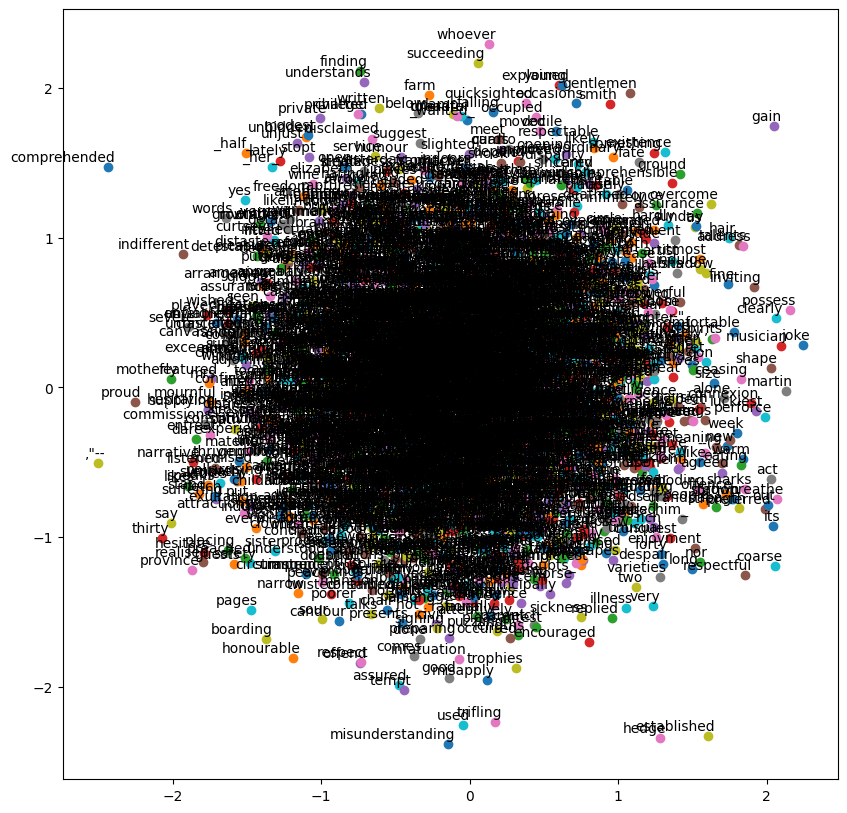

In [32]:
# let's plot the embedding

plt.figure(figsize=(10,10))
for i, label in enumerate(word2index.keys()):
    x, y = get_embed(label)
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()


In [33]:
model.embedding_v.weight.data


tensor([[-0.7416,  1.8543],
        [-0.5346,  0.2949],
        [-1.9751,  0.6436],
        ...,
        [-0.8939,  0.2124],
        [ 0.0924, -0.2122],
        [ 1.4203,  0.4396]])

In [ ]:
# my corpus may be quite too big ! i need to try with a smaller corpus again next time! 
